# Transformation + correlation analysis

This notebook examines the correlation structure in the gene expression data generated in [1_create_compendia.ipynb](../processing/1_create_compendia.ipynb).

When we performed clustering on the correlation matrices (using Pearson correlation) we found that pairs of genes had either very high correlation scores (>0.5) or very low correlation scores (<0.1). As a result gene pairs that were highly correlated clustered into a single large module. This clustering pattern is not ideal for a couple of reasons:
1. Given that our goal is to examine the composition of gene groups, having all genes within one module does not allow us to do this
2. These highly correlated group of genes are likely masking other relevant specific signals/relationships in the data

Here we will apply transformations of the raw gene expression data before applying clustering to see if this helps to correct for this high level of correlation

In [1]:
%load_ext autoreload
%autoreload 2
import os
import pandas as pd
import plotnine as pn
import seaborn as sns
import matplotlib.pyplot as plt
import umap
import random
import numpy as np
from sklearn import preprocessing
from core_acc_modules import paths

/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


## Set user parameters

For now we will vary the correlation threshold (`corr_threshold`) but keep the other parameters consistent

We will run this notebook for each threshold parameter

In [2]:
# Params -- REMOVE???
corr_threshold = 0.5

# Output files
pao1_membership_filename = f"pao1_membership_{corr_threshold}.tsv"
pa14_membership_filename = f"pa14_membership_{corr_threshold}.tsv"

In [3]:
# Load expression data
pao1_compendium_filename = paths.PAO1_COMPENDIUM
pa14_compendium_filename = paths.PA14_COMPENDIUM

In [4]:
pao1_compendium = pd.read_csv(pao1_compendium_filename, sep="\t", header=0, index_col=0)
pa14_compendium = pd.read_csv(pa14_compendium_filename, sep="\t", header=0, index_col=0)

In [5]:
print(pao1_compendium.shape)
pao1_compendium.head()

(847, 5563)


,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA1905,PA0195,PA4812,PA0195.1,PA0457.1,PA1552.1,PA1555.1,PA3701,PA4724.1,PA5471.1
ERX541579,150.908951,63.968306,56.863002,86.013480,32.240954,48.322611,21.099413,21.219456,31.521424,12.168960,...,0.000000,16.606783,38.218939,8.611779,28.396413,110.943698,137.583940,101.058282,65.210599,0.000000
ERX541580,108.323515,56.079007,57.001674,73.421480,18.426169,46.572630,16.606703,18.595344,30.253393,15.936006,...,0.000000,13.904292,37.246074,11.777708,45.733000,94.799523,53.486191,82.753701,23.340646,38.113576
ERX541591,556.704228,182.309588,81.730476,157.348561,85.185006,116.643999,36.964524,31.973493,63.109930,16.140763,...,14.312595,73.032021,80.369628,49.312460,69.099677,61.622295,103.911157,186.030844,478.965167,0.000000
ERX541592,428.470250,178.510235,74.953217,152.142022,92.393069,95.317522,33.668009,31.262234,81.131515,20.126563,...,6.691671,114.618032,62.583672,56.426453,58.473904,55.311934,101.620394,207.409539,345.057960,0.000000
ERX676205,555.932721,530.701952,295.028891,336.887163,160.855884,196.799841,24.062303,127.448405,251.543954,29.933785,...,9.935461,59.660341,268.159400,40.929204,30.272774,284.146647,357.806954,260.651493,110.621722,0.000000


In [6]:
print(pa14_compendium.shape)
pa14_compendium.head()

(520, 5891)


,PA14_55610,PA14_55600,PA14_55590,PA14_55580,PA14_55570,PA14_55560,PA14_55550,PA14_55540,PA14_55530,PA14_55520,...,PA14_19205,PA14_17675,PA14_67975,PA14_36345,PA14_43405,PA14_38825,PA14_24245,PA14_28895,PA14_55117,PA14_59845
ERX1477379,11.030217,1.370300,0.683438,63.527772,34.586977,4.709054,5.274344,8.137393,5.310585,0.766974,...,10.688588,82.981151,63.650349,28.877599,7.956130,56.829502,269.183334,6.074311,29.079407,100.748813
ERX1477380,13.419626,3.039174,1.334504,105.003820,70.493150,8.849012,6.802855,18.784232,11.978251,2.088495,...,15.823345,91.090917,62.400165,24.819442,3.132517,31.325168,181.774134,10.866863,16.090103,233.317754
ERX1477381,13.155391,5.684725,7.208220,143.201487,107.849795,12.753058,8.868100,27.482294,13.951196,1.251785,...,28.406181,98.909427,71.429549,24.114657,6.515803,18.616579,184.357151,13.112427,13.970424,93.182566
ERX2174773,4.201447,4.194614,3.283683,3.273384,20.188057,3.804287,2.665245,2.650568,20.062716,3.755125,...,41.954387,35.821193,114.727681,104.737209,0.000000,391.722223,160.215744,18.980486,20.985404,182.605858
ERX2174774,5.016892,3.306859,3.446703,2.676762,17.199329,3.748607,1.618736,4.083091,21.225030,2.373772,...,44.138587,26.599121,105.848301,104.402335,0.000000,444.485136,168.538985,24.906987,19.775702,206.865218


## Correlation of raw gene expression data

Use this as a comparison to see how the correlations are changed after each correction method

In [7]:
# Correlation
pao1_corr_original = pao1_compendium.corr()
pa14_corr_original = pa14_compendium.corr()

In [8]:
pao1_corr_original.head(10)

,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA1905,PA0195,PA4812,PA0195.1,PA0457.1,PA1552.1,PA1555.1,PA3701,PA4724.1,PA5471.1
PA0001,1.000000,0.463956,0.569484,0.351438,0.245083,0.082922,-0.237419,0.327681,0.611781,-0.053683,...,-0.143054,0.067547,-0.046884,0.115943,0.095939,0.137961,0.123254,0.413492,-0.017787,-0.044556
PA0002,0.463956,1.000000,0.252376,0.748150,0.165336,-0.064989,-0.223772,0.474954,0.404363,-0.091208,...,-0.049508,-0.029025,0.068886,0.066085,-0.081798,0.364207,0.230212,0.295833,-0.003284,0.026462
PA0003,0.569484,0.252376,1.000000,0.370005,0.231063,0.305920,-0.227813,0.226757,0.414430,0.044911,...,-0.161805,-0.105521,0.058363,-0.032366,0.118532,0.204444,0.136097,0.330368,-0.000470,-0.053666
PA0004,0.351438,0.748150,0.370005,1.000000,0.178458,-0.013829,-0.289639,0.519269,0.406310,-0.039080,...,-0.141347,-0.146768,0.188109,-0.079627,0.004548,0.385017,0.265849,0.248906,-0.068307,-0.074792
PA0005,0.245083,0.165336,0.231063,0.178458,1.000000,0.494013,0.054159,0.548067,0.458342,0.600835,...,0.028263,0.156724,0.147440,0.288880,0.274439,0.158833,-0.076657,0.376051,0.323167,0.055236
PA0006,0.082922,-0.064989,0.305920,-0.013829,0.494013,1.000000,0.081308,0.237252,0.292878,0.513892,...,-0.016893,0.096924,0.010410,0.117019,0.360544,-0.003778,-0.102584,0.271246,0.500298,0.151742
PA0007,-0.237419,-0.223772,-0.227813,-0.289639,0.054159,0.081308,1.000000,-0.046221,-0.216576,0.324133,...,0.271006,0.185148,0.153610,0.229573,0.014695,-0.157321,-0.194364,-0.228108,-0.011214,-0.075471
PA0008,0.327681,0.474954,0.226757,0.519269,0.548067,0.237252,-0.046221,1.000000,0.622803,0.422828,...,0.025600,0.171674,0.098219,0.160160,0.275832,0.292958,-0.004170,0.373103,0.033407,-0.062744
PA0009,0.611781,0.404363,0.414430,0.406310,0.458342,0.292878,-0.216576,0.622803,1.000000,0.323238,...,-0.086027,0.190834,0.041047,0.263861,0.181747,0.288218,0.090151,0.649253,0.211386,0.008422
PA0010,-0.053683,-0.091208,0.044911,-0.039080,0.600835,0.513892,0.324133,0.422828,0.323238,1.000000,...,0.214372,0.368324,0.054038,0.459551,0.241080,-0.065073,-0.135702,0.145646,0.278227,-0.063221


In [9]:
pa14_corr_original.head(10)

,PA14_55610,PA14_55600,PA14_55590,PA14_55580,PA14_55570,PA14_55560,PA14_55550,PA14_55540,PA14_55530,PA14_55520,...,PA14_19205,PA14_17675,PA14_67975,PA14_36345,PA14_43405,PA14_38825,PA14_24245,PA14_28895,PA14_55117,PA14_59845
PA14_55610,1.000000,0.906701,0.749071,0.162668,0.266153,0.275753,0.588848,0.160785,0.652794,0.713892,...,0.533793,0.227351,0.082841,0.063174,-0.024971,0.059939,-0.029175,0.624167,0.613477,0.070253
PA14_55600,0.906701,1.000000,0.850899,0.156404,0.262327,0.288455,0.564872,0.168042,0.658406,0.723227,...,0.632673,0.222953,0.106674,0.046272,-0.023670,0.043219,-0.103563,0.674299,0.422937,0.040578
PA14_55590,0.749071,0.850899,1.000000,0.130853,0.193168,0.197765,0.359634,0.122212,0.499659,0.527222,...,0.504701,0.143781,0.075238,0.017656,-0.022301,-0.049487,-0.116984,0.452168,0.357768,0.019400
PA14_55580,0.162668,0.156404,0.130853,1.000000,0.715461,0.157864,0.189221,0.072951,0.250444,0.106665,...,0.104985,-0.140209,-0.251613,0.036440,-0.012161,0.073282,-0.040502,0.057864,0.101350,0.067545
PA14_55570,0.266153,0.262327,0.193168,0.715461,1.000000,0.362644,0.379303,0.366620,0.440662,0.297628,...,0.223022,-0.112091,-0.224259,0.063502,-0.031547,0.048680,-0.072413,0.155098,0.139406,0.086553
PA14_55560,0.275753,0.288455,0.197765,0.157864,0.362644,1.000000,0.796257,0.228080,0.478695,0.591215,...,0.192297,-0.020132,-0.082234,0.009302,0.017292,-0.008538,-0.086910,0.256650,0.118795,0.243433
PA14_55550,0.588848,0.564872,0.359634,0.189221,0.379303,0.796257,1.000000,0.294181,0.650316,0.821997,...,0.376162,0.110074,0.038220,0.043972,0.026152,0.064738,-0.040994,0.545006,0.291638,0.144242
PA14_55540,0.160785,0.168042,0.122212,0.072951,0.366620,0.228080,0.294181,1.000000,0.220546,0.288728,...,0.100791,0.008243,-0.127802,-0.016647,-0.018001,0.161880,-0.136225,0.134484,0.091419,-0.046814
PA14_55530,0.652794,0.658406,0.499659,0.250444,0.440662,0.478695,0.650316,0.220546,1.000000,0.789647,...,0.645462,0.190459,-0.055140,0.079046,-0.026326,-0.020371,-0.089501,0.611433,0.432119,0.201573
PA14_55520,0.713892,0.723227,0.527222,0.106665,0.297628,0.591215,0.821997,0.288728,0.789647,1.000000,...,0.570803,0.176055,0.087168,0.060785,-0.016582,0.001728,-0.088387,0.764914,0.383719,0.061344


## Scaling + correlation

Try different processing of the raw gene expression data and then applying correlation:
* log transform + correlation
* Normalize + correlation

### Log transform + correlation

In [10]:
# log transform data
pao1_compendium_log10 = np.log10(pao1_compendium)
pa14_compendium_log10 = np.log10(pa14_compendium)

/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  
/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


In [11]:
# Correlation
pao1_corr_log10 = pao1_compendium_log10.corr()
pa14_corr_log10 = pa14_compendium_log10.corr()

Text(0.5, 1.05, 'Correlation of log10 transformed PAO1 genes')

<Figure size 1440x1440 with 0 Axes>

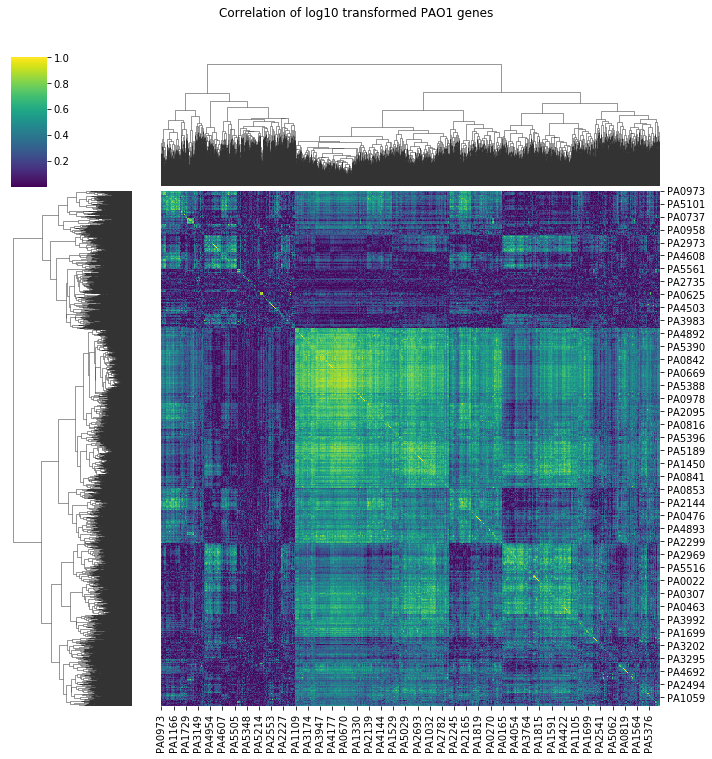

In [12]:
# Plot heatmap
plt.figure(figsize=(20, 20))
h1 = sns.clustermap(pao1_corr_log10.abs(), cmap="viridis")
h1.fig.suptitle("Correlation of log10 transformed PAO1 genes", y=1.05)

Text(0.5, 1.05, 'Correlation of log10 transformed PA14 genes')

<Figure size 1440x1440 with 0 Axes>

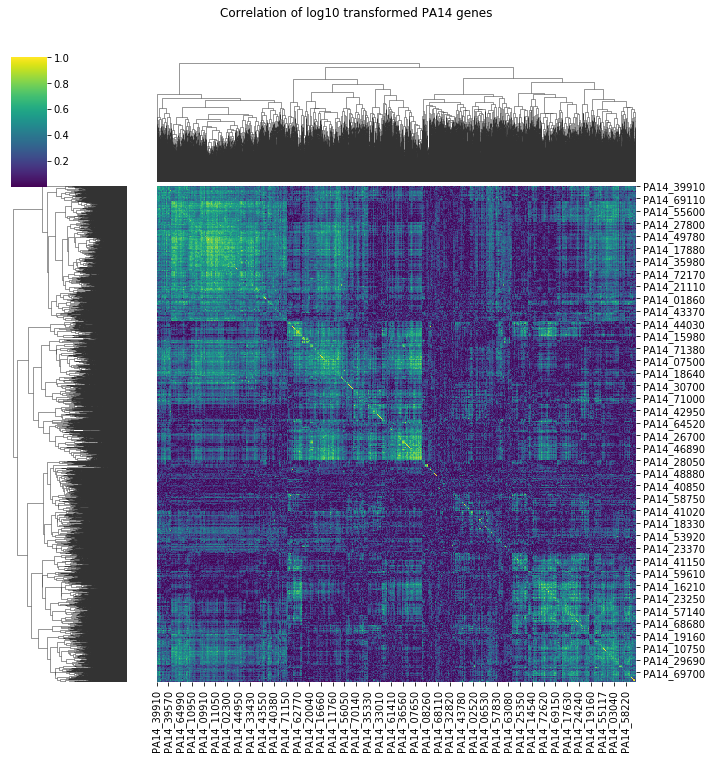

In [13]:
plt.figure(figsize=(20, 20))
h2 = sns.clustermap(pa14_corr_log10.abs(), cmap="viridis")
h2.fig.suptitle("Correlation of log10 transformed PA14 genes", y=1.05)

### 0-1 normalize + correlation

In [17]:
# 0-1 normalize per gene
scaler = preprocessing.MinMaxScaler()

pao1_scaled = scaler.fit_transform(pao1_compendium)
pao1_scaled_df = pd.DataFrame(
    pao1_scaled, columns=pao1_compendium.columns, index=pao1_compendium.index
)

scaler2 = preprocessing.MinMaxScaler()
pa14_scaled = scaler2.fit_transform(pa14_compendium)
pa14_scaled_df = pd.DataFrame(
    pa14_scaled, columns=pa14_compendium.columns, index=pa14_compendium.index
)

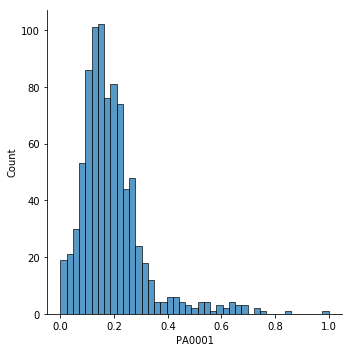

In [18]:
sns.displot(pao1_scaled_df["PA0001"])

In [19]:
# Correlation
pao1_corr_normalized = pao1_scaled_df.corr()
pa14_corr_normalized = pa14_scaled_df.corr()

Text(0.5, 1.05, 'Correlation of 0-1 normalized PAO1 genes')

<Figure size 1440x1440 with 0 Axes>

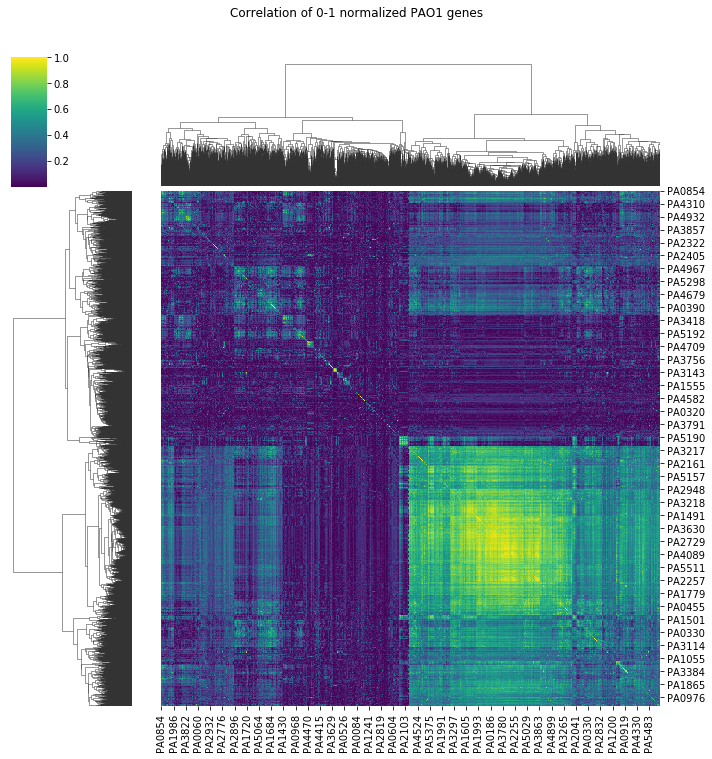

In [20]:
# Plot heatmap
plt.figure(figsize=(20, 20))
h3 = sns.clustermap(pao1_corr_normalized.abs(), cmap="viridis")
h3.fig.suptitle("Correlation of 0-1 normalized PAO1 genes", y=1.05)

Text(0.5, 1.05, 'Correlation of 0-1 normalized PA14 genes')

<Figure size 1440x1440 with 0 Axes>

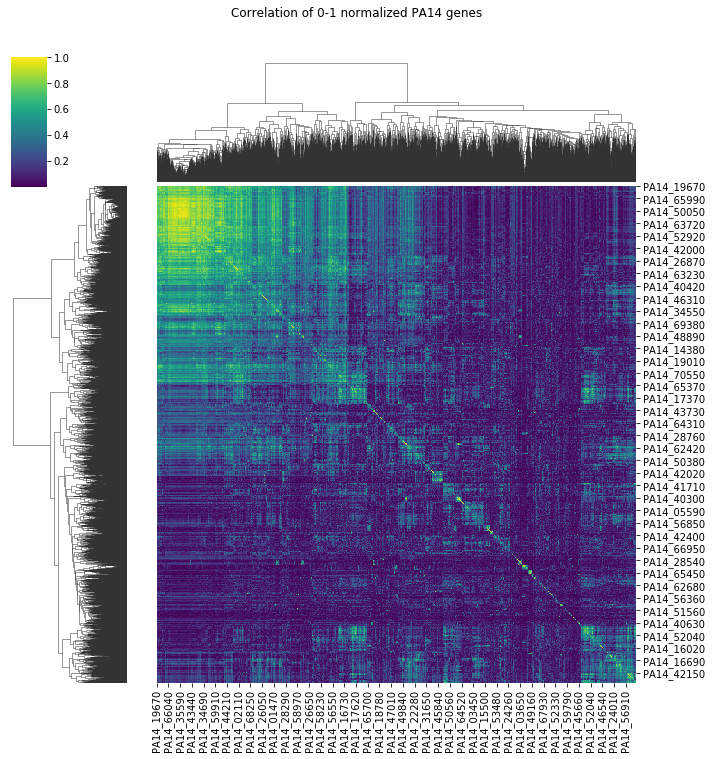

In [21]:
plt.figure(figsize=(20, 20))
h4 = sns.clustermap(pa14_corr_normalized.abs(), cmap="viridis")
h4.fig.suptitle("Correlation of 0-1 normalized PA14 genes", y=1.05)

**Takeaway:**